In [1]:
!pip install sgp4
# dont forget to upload world.npy

In [2]:
## extention of "https://docs.astropy.org/en/stable/coordinates/frames.html"
import numpy as np
import pylab as pl
import time
from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import ITRS
from astropy.coordinates import EarthLocation, AltAz
#cp.cuda.Stream.null.synchronize()

In [3]:
## create satellite object

s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
satellite = Satrec.twoline2rv(s, t)
world = np.load('world.npy')

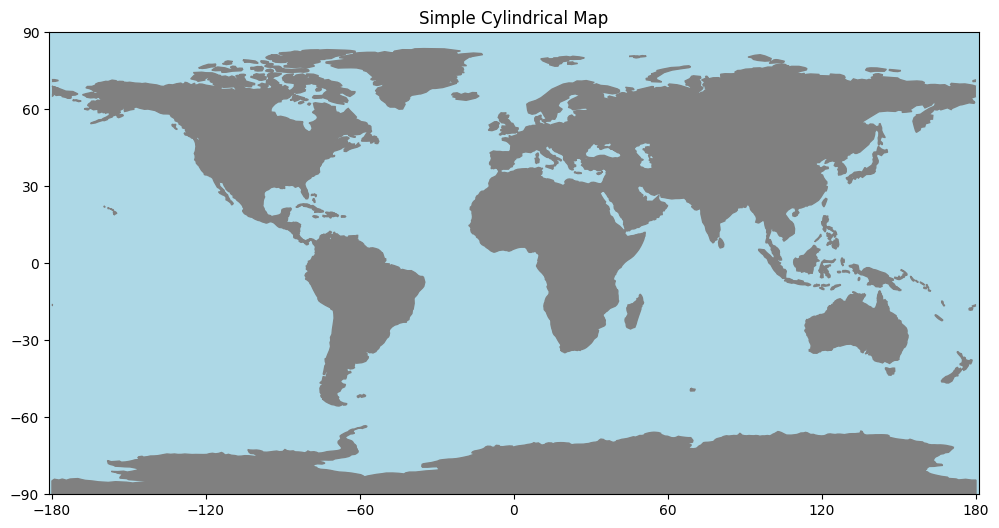

In [4]:
# simple map plotting routine

def plot_world_map():
    fig, ax = pl.subplots(1, figsize=(12, 6))
    ax.set_xticks(np.arange(-180, 181, 60))
    ax.set_yticks(np.arange(-90, 91, 30))
    antarctica = world[:,1] < -60
    ant = world[antarctica]
    start = np.argmin(ant[:,0])
    stop = np.argmax(ant[:,0])
    length = stop - start
    ant = np.roll(ant, -start, axis=0)[:length]
    ant = np.vstack([[-180, -90], ant, [180, ant[-1,1]], [180, -90]])
    rest = world[np.logical_not(antarctica)]
    w = np.vstack([rest, [np.nan, np.nan], ant])
    ax.set_facecolor('lightblue')

    ax.fill(w[:,0], w[:,1], color='grey', alpha=1)
    ax.axis('equal')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    return fig, ax
fig, ax = plot_world_map()
j = ax.set_title("Simple Cylindrical Map")


In [5]:
## Generate an array of Time objects
times = [Time(2458827.362605 + i/86400., format='jd') for i in range(2 * 3600)]
jd = np.array([(t.jd1, t.jd2) for t in times])
print(f'{len(times)} time points.')

7200 time points.


In [6]:
## Generate an epheris block (in inertial coordinates)
start = time.time()
ephem = np.array([satellite.sgp4(t.jd1, t.jd2)[1:] for t in times])
print(f'Ran in {time.time() - start} Seconds')

Ran in 0.12712931632995605 Seconds


In [7]:
### Check shape of ephem array
ephem.shape

(7200, 2, 3)

In [8]:
## convert to n X 6 array of position and velocities
ephem = ephem.reshape((-1, 6))
ephem.shape

(7200, 6)

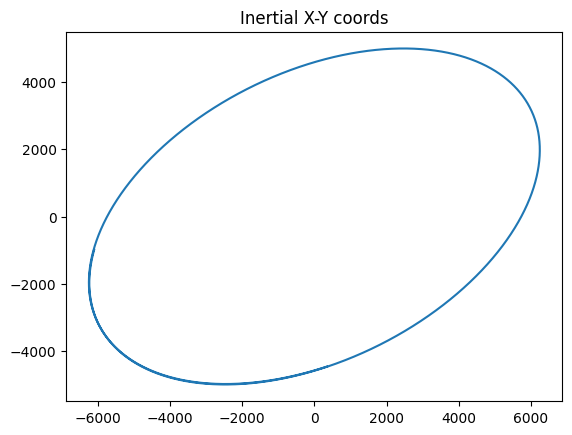

In [9]:
pl.figure()
pl.plot(ephem[:,0], ephem[:,1])
j = pl.title('Inertial X-Y coords')

In [10]:
## Set up rotation matrices to convert inertial coords to Earth-Fixed coords
sidereal_day = 23 * 3600 + 56 * 60 + 4.09
DEG = np.pi / 180
omega = 2 * np.pi/ sidereal_day
theta = omega * np.arange(len(times))

cost = np.cos(theta)
sint = np.sin(theta)
R = np.zeros((len(theta), 3, 3))
R[:,2,2] = 1
R[:,0,0] = cost
R[:,1,1] = cost
R[:,0,1] = -sint
R[:,1,0] =  sint

In [11]:
## Generate Earth-Fixed ephemeris
pos_ecf = np.einsum('nij,nj->ni', R, ephem[:,:3])

## check einsum args are producing intended output
check_i = 1
assert np.linalg.norm(R[check_i] @ ephem[check_i,:3] - pos_ecf[check_i]) < 1e-8

Text(0.5, 1.0, 'Ground Track')

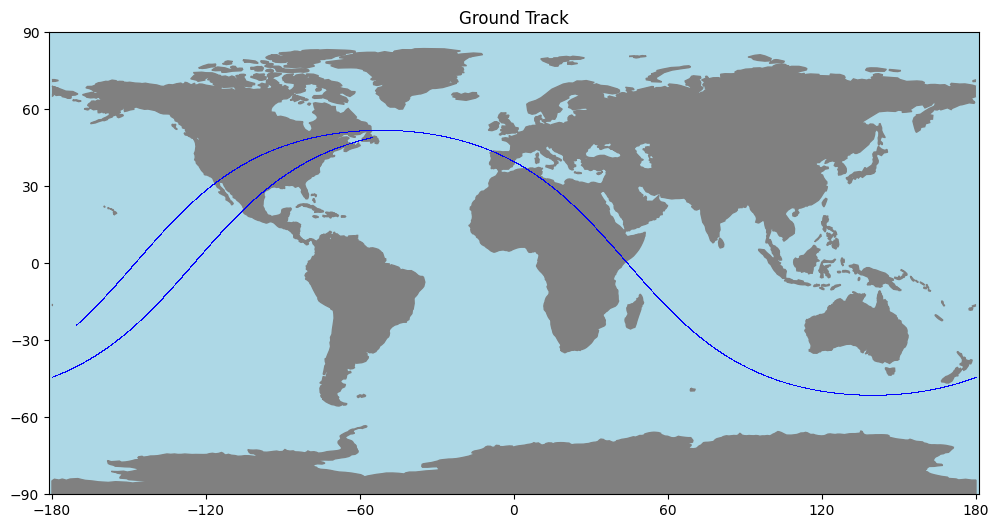

In [12]:
## plot ground track using geodetic latitude
x = pos_ecf[:,0]
y = pos_ecf[:,1]
z = pos_ecf[:,2]
sat_lon = np.arctan2(y, x)
sat_lat = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
fig, ax = plot_world_map()
ax.plot(sat_lon / DEG, sat_lat / DEG, 'b,')
ax.set_title("Ground Track")


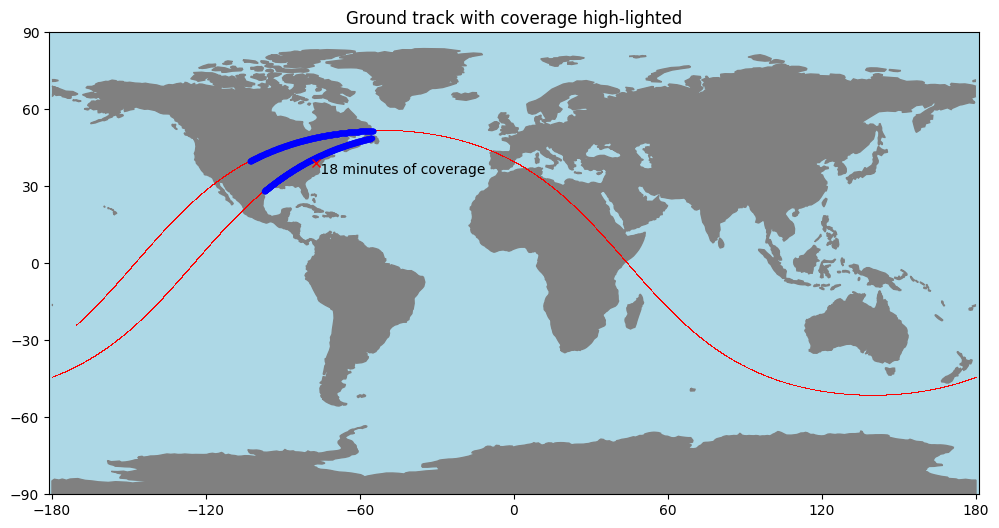

In [13]:
def get_visibility(pos_ecf, g):
    '''
    Compute line-of-sight visibility from ecf space pos to ecf ground pos g
    pos_ecf -- Nx3 array, ecf positions
          g -- 3 array, ecf ground location
    returns N array of booleans (True if visibile, False otherwise)
    '''
    #g = np.array(g)
    doa = (g - pos_ecf)
    inview = -doa @ g > 0
    return inview
def get_coverage(pos_ecf, g, dt):
    '''
    Compute total coverage from ecf space pos to ecf ground pos g
    pos_ecf -- Nx3 array, ecf positions
          g -- 3 array, ecf ground location
    returns total time inview
    '''
    inview = get_visibility(pos_ecf, g)
    return sum(inview) * dt


earth_lat = 39 * DEG
earth_lon = -77 * DEG
#earth_lat = -23 * DEG
#earth_lon = -170 * DEG
EARTH_RADIUS = 6378.137
g = EARTH_RADIUS * np.array([np.cos(earth_lat) * np.cos(earth_lon),
                             np.cos(earth_lat) * np.sin(earth_lon),
                             np.sin(earth_lat)])
v = get_visibility(pos_ecf, g)
fig, ax = plot_world_map()
ax.plot(sat_lon / DEG, sat_lat / DEG, 'r,')
ax.plot(sat_lon[v] / DEG, sat_lat[v] / DEG, 'b.')
ax.plot(earth_lon / DEG, earth_lat / DEG, 'rx')
ax.axis('equal')
ax.set_title('Ground track with coverage high-lighted')
ax.text(earth_lon/ DEG, earth_lat / DEG,
        f' {get_coverage(pos_ecf, g, 1.)/60:.0f} minutes of coverage',
        ha='left', va='top', color='k')
ax.set_xlim(-180, 180)
j = ax.set_ylim(-90, 90)

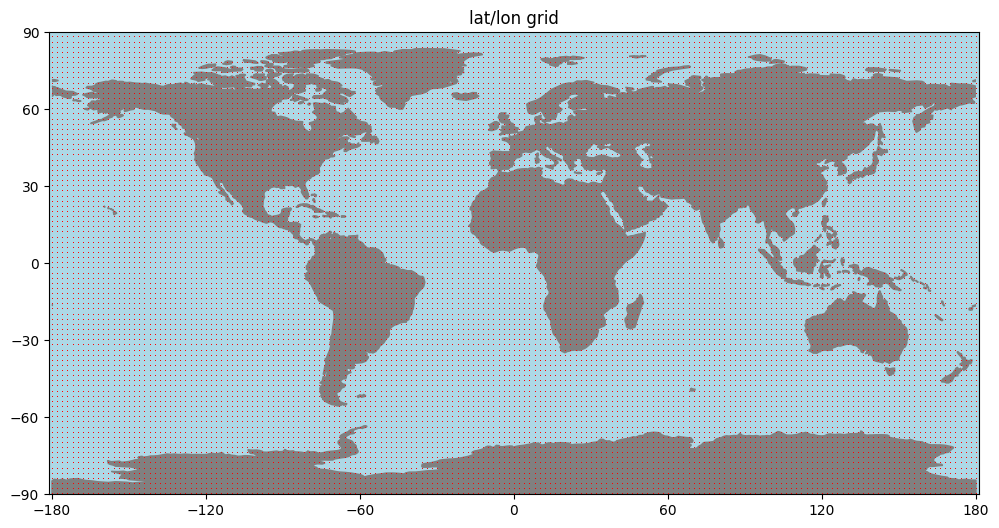

In [14]:
## make grid of geodetic lat/lon points
_lat = np.linspace(-90, 90, 91) * DEG
_lon = np.linspace(-180, 180, 181) * DEG
EARTH_RADIUS = 6378.137

grid_lat, grid_lon = np.meshgrid(_lat, _lon)
grid_lat = grid_lat.ravel()
grid_lon = grid_lon.ravel()
gx = EARTH_RADIUS * np.cos(grid_lat) * np.cos(grid_lon)
gy = EARTH_RADIUS * np.cos(grid_lat) * np.sin(grid_lon)
gz = EARTH_RADIUS * np.sin(grid_lat)
g_ecf = np.column_stack([gx, gy, gz])
up = g_ecf / EARTH_RADIUS
fig, ax = plot_world_map()
ax.plot(grid_lon / DEG, grid_lat / DEG, 'r,')
ax.axis('equal')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
j = pl.title("lat/lon grid")

In [15]:
## compute coverage over full grid using for loop
start = time.time()
coverage = np.array([get_coverage(pos_ecf, g, 1) for g in g_ecf])
print(f'{time.time() - start} seconds to compute coverag using list comprehension.')

46.72692561149597 seconds to compute coverag using list comprehension.


In [16]:
## now try numpy broadcasting
def get_visibility_np(pos_ecf, g_ecf):
    doa = (g_ecf[:,np.newaxis] - pos_ecf[np.newaxis,:])
    inview = np.einsum('gni,gi->gn', -doa, g_ecf) > 0
    return inview

def get_coverage_np(pos_ecf, g_ecf):
    inview = get_visibility_np(pos_ecf, g_ecf)
    return np.sum(inview, axis=1)

start = time.time()
coverage_np = get_coverage_np(pos_ecf, g_ecf)
print(f'{time.time() - start} seconds to compute using numpy.')

4.214318752288818 seconds to compute using numpy.


In [17]:
## now try cupy ##
import cupy as cp
pos_ecf_cp = cp.array(pos_ecf)
g_ecf_cp = cp.array(g_ecf)

def get_visibility_cp(pos_ecf_cp, g_ecf_cp):
    doa = (g_ecf_cp[:,cp.newaxis] - pos_ecf_cp[cp.newaxis,:])
    inview = cp.einsum('gni,gi->gn', -doa, g_ecf_cp) > 0
    return inview

def get_coverage_cp(pos_ecf_cp, g_ecf_cp):
    inview = get_visibility_cp(pos_ecf_cp, g_ecf_cp)
    return cp.sum(inview, axis=1)

start = time.time()
coverage_cp = get_coverage_cp(pos_ecf_cp, g_ecf_cp)
print(f'{time.time() - start} seconds to compute using cupy.')

0.30965662002563477 seconds to compute using cupy.


In [18]:
### make sure answers agree
print(' ||numpy - cupy||?', np.linalg.norm(coverage_cp.get() - coverage_np))
print('||python - cupy||?', np.linalg.norm(coverage_cp.get() - coverage))

 ||numpy - cupy||? 0.0
||python - cupy||? 0.0


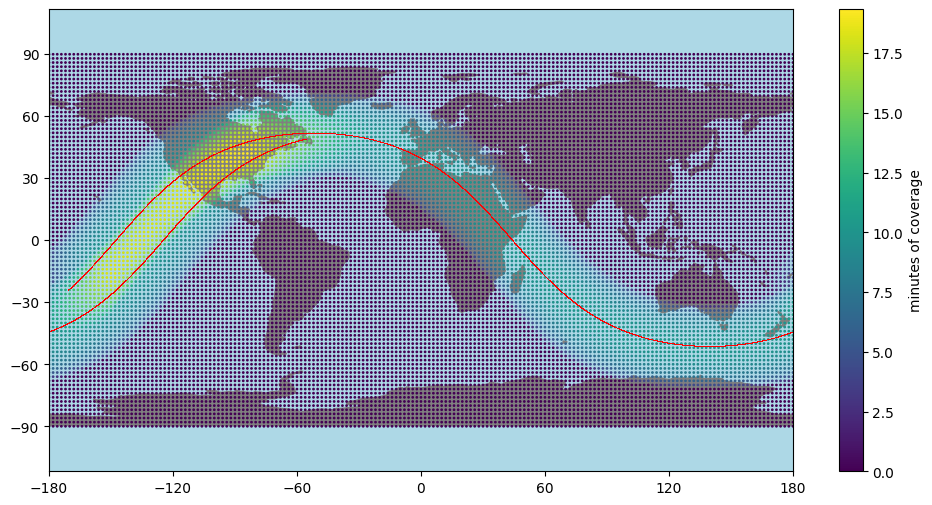

In [19]:
fig, ax = plot_world_map()
mappable = ax.scatter(grid_lon / DEG, grid_lat / DEG, c=coverage/60, s=1, marker='o')
j = ax.plot(sat_lon / DEG, sat_lat / DEG, 'r,')
fig.colorbar(mappable=mappable, label='minutes of coverage')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
fig.savefig('coverage.png')